## ATENÇÃO!!!!!!

### Esse notebook trabalha assumindo uma matriz de espécie anual sem $S_{2,2}$ 


In [72]:
rm(list=ls());gc()

          used  (Mb) gc trigger  (Mb) max used  (Mb)
Ncells 4486199 239.6    7890150 421.4  7890150 421.4
Vcells 8114095  62.0   14786712 112.9 14786700 112.9

# README

<!--#  Reorganizar essa ordem e atualizar os novos tópicos adicionados: elasticidade e LTRE-->

1.  Creates an accessory function to automatize the implementation of the Quadratic Programming inverse method (QP therefore)

2.  Estimate survival, stasis and growth using the `QPmat`from `popbio` package

    1.  Step 1. Define the rules/constraints that must be given to the QP - Quadratic programming

        -   $C$, $b$ , non-zeros
        -   Automatise this process with a dedicated ancillary function `WoodPar`

3.  Reach a best method to estimate recruitment, as it cannot be directly estimated with QP

4.  Apply QP and retrieve MPMs

5.  Complement MPMs with recruitment

6.  Calculate lambda and plot results

7.  Population viability

    7.1. Simulations with reducing vital rates'

    
# 1. Packages and SessionInfo

In [73]:
library(popbio)
library(ggplot2)
library(tidyverse)
library(openxlsx)
library(ggrepel)
library(ggridges)
library(broom)

set.seed(1)
sessionInfo()

R version 4.4.1 (2024-06-14 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 22631)

Matrix products: default


locale:
[1] LC_COLLATE=Portuguese_Brazil.utf8  LC_CTYPE=Portuguese_Brazil.utf8   
[3] LC_MONETARY=Portuguese_Brazil.utf8 LC_NUMERIC=C                      
[5] LC_TIME=Portuguese_Brazil.utf8    

time zone: America/Sao_Paulo
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] scales_1.3.0       MuMIn_1.48.4       glmmTMB_1.1.10     performance_0.12.4
 [5] DHARMa_0.4.7       lme4_1.1-35.5      Matrix_1.7-0       broom_1.0.7       
 [9] ggridges_0.5.6     ggrepel_0.9.5      openxlsx_4.2.7.1   lubridate_1.9.3   
[13] forcats_1.0.0      stringr_1.5.1      dplyr_1.1.4        purrr_1.0.2       
[17] readr_2.1.5        tidyr_1.3.1        tibble_3.2.1       tidyverse_2.0.0   
[21] ggplot2_3.5.1      popbio_2.8        

loaded via a namespace (and not attach


# 2. Data Loading and standardization


In [74]:
Mar22<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Março2022")
Abr22<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Abril2022")
Mai22<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Maio2022")

### 2023
Mar23<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Março2023")
Abr23<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Abril2023")
Mai23<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Maio2023")

### 2024
Mar24<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Março2024")
Abr24<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Abril2024")
Mai24<-read.xlsx("Dados brutos/Dados parapiqueria - Completo - Consolidado 05Aug2024.xlsx",sheet="Maio2024")


## 2.1. Prepare final datasets: Merging censuses & summarise
-   Step 1: Merge monthly censuses –\> Merge census across the years

    Censuses are performed every March, April and May and need to merged to produce a timeserie.

    -   Two datasets were produced
        -   A timeserie (Mar-May) to run QPmat
        -   A maximum number of individuals each year to estimate recruitment
            -   Censuses from different years must be paired

## 2.2. Merge censuses

<!--Quadrants are not relevant for the analyses, so it is removed in the data handling process`-->


In [75]:
census2024<-rbind(
  data.frame(Mar24,Month="3"),
  data.frame(Abr24,Month="4"),
  data.frame(Mai24,Month="5"))%>%
  as_tibble()%>%
  group_by(Site,Plot,Month)%>%    #Quadrants not included
  summarise(Imaturos=sum(Imaturos),
            Reprodutivos=sum(Reprodutivos))%>%
  ungroup()


### 2023
census2023<-rbind(
  data.frame(Mar23,Month="3"),
  data.frame(Abr23,Month="4"),
  data.frame(Mai23,Month="5"))%>%
  as_tibble()%>%
  group_by(Site,Plot,Month)%>%
  summarise(Imaturos=sum(Imaturos),
            Reprodutivos=sum(Reprodutivos))%>%
  ungroup()

### 2022
census2022<-rbind(
  data.frame(Mar22,Month="3"),
  data.frame(Abr22,Month="4"),
  data.frame(Mai22,Month="5"))%>%
  select(Site,Plot,Imaturos,Reprodutivos,Month)

census2022 # An example of a census merged along the year

#----------------------------------------------------
# Now merge the census across the years
#----------------------------------------------------

Census_all<-rbind(
  cbind(census2024,year="2024"),
  cbind(census2023,year="2023"),
  cbind(census2022,year="2022"))%>%
  pivot_longer(Imaturos:Reprodutivos,names_to="stage")


#### Maximum number of individuals
Census_all_max<-rbind(
  cbind(census2024,year="2024"),
  cbind(census2023,year="2023"),
  cbind(census2022,year="2022"))%>%
  group_by(Site,year,Plot)%>%
  summarise(MaxIm=max(Imaturos),
            MaxRep=max(Reprodutivos))%>%
  mutate(MaxTot=ifelse(MaxIm>MaxRep,MaxIm,MaxRep))%>%
  pivot_longer(MaxIm:MaxTot,names_to="stage")


Census_all #View

Census_all_max  #View



`summarise()` has grouped output by 'Site', 'Plot'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Site', 'Plot'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'Site', 'year'. You can override using the
`.groups` argument.


### 2.3. Pairing censuses to estimate recruitment

In [76]:
Timelags_base<-Census_all_max %>%
  mutate(year = as.numeric(year)) %>%        # make sure year is a numeric column
  group_by(Plot) %>%                         
  arrange(year, stage) %>%    # It is important to get all arranged as lead is dependent of the dataset order!                
  mutate(VAR = paste0(stage, ">", 
                      lead(stage, order_by = interaction(year,stage)))) %>%
# Store initial and next year to calculate recruitment
  mutate(t0y = year,
         t1y = lead(year, order_by = VAR))%>%   #lead function gets the next value, so, t+1 as they are sorted
  mutate(t0 = value, 
         t1 = lead(value, order_by = VAR)) %>% 
  # filters only years were t+1 (t1y) is older than initial year t (t0y),
  filter(t1y>t0y)%>%	#If this order is not what you want, change interaction to return same year variables
  arrange(Plot,VAR)

#### Max Rep in t0 vs. MaxTot in t1
#Pairing Maximum reprodutctive to Max Total

RepTot<-left_join(
  filter(Timelags_base,stage=="MaxRep")%>%select(Site:Plot,t0y,t0),  #Filter reproductive from t and total recruited individuals from t+1 (next line)
  filter(Timelags_base,stage=="MaxTot")%>%select(Site:Plot,t1y,t1))%>%
  mutate(VAR="MaxRep>MaxTot")%>%
  select(VAR,Site:t0y,t1y,t0,t1)%>%	#Reorder columns
  mutate(Site=as.factor(Site))%>%
  mutate(period=as.factor(paste0(t0y,"-",t1y)))

##### Max Rep in t0 vs. MaxIm in t1

RepIm<-left_join(
  filter(Timelags_base,stage=="MaxRep")%>%select(Site:Plot,t0y,t0),
  filter(Timelags_base,stage=="MaxIm")%>%select(Site:Plot,t1y,t1))%>%
  mutate(VAR="MaxRep>MaxIm")%>%
  select(VAR,Site:t0y,t1y,t0,t1)%>%	#Reorder columns
  mutate(Site=as.factor(Site))%>%
  mutate(period=as.factor(paste0(t0y,"-",t1y)))

RepTot # Exemplo de resultado


Joining with `by = join_by(Site, year, Plot)`
Joining with `by = join_by(Site, year, Plot)`



### 2.4. Transform censuses in timeseries to estimate survival


In [77]:
## 2024
Census2024_ts<-census2024%>%arrange(Site,Plot,Month)%>%
select(Plot,Month,Imaturos,Reprodutivos)%>%
pivot_longer(c(Imaturos,Reprodutivos),names_to="Stage",values_to="Indv")%>%
pivot_wider(names_from=Month,values_from="Indv")%>%
arrange(Plot)%>%
mutate(Plot_tag=paste0("Plot_",Plot))%>%
select(-c(Stage,Plot))%>%
 group_split(Plot_tag, .keep = TRUE) %>%
  `names<-`({.} %>% map(~ .x$Plot_tag[1]) %>% unlist()) %>%
  ## If you want to discard the grouping variable, do the following step as well
  map(~ .x %>% select(-Plot_tag))

#Census2024_ts

## 2023
Census2023_ts<-census2023%>%arrange(Site,Plot,Month)%>%
select(Plot,Month,Imaturos,Reprodutivos)%>%
pivot_longer(c(Imaturos,Reprodutivos),names_to="Stage",values_to="Indv")%>%
pivot_wider(names_from=Month,values_from="Indv")%>%
arrange(Plot)%>%
mutate(Plot_tag=paste0("Plot_",Plot))%>%
select(-c(Stage,Plot))%>%
 group_split(Plot_tag, .keep = TRUE) %>%
  `names<-`({.} %>% map(~ .x$Plot_tag[1]) %>% unlist()) %>%
  ## If you want to discard the grouping variable, do the following step as well
  map(~ .x %>% select(-Plot_tag))

#Census2023_ts


## 2022
Census2022_ts<-census2022%>%arrange(Site,Plot,Month)%>%
select(Plot,Month,Imaturos,Reprodutivos)%>%
pivot_longer(c(Imaturos,Reprodutivos),names_to="Stage",values_to="Indv")%>%
pivot_wider(names_from=Month,values_from="Indv")%>%
arrange(Plot)%>%
mutate(Plot_tag=paste0("Plot_",Plot))%>%
select(-c(Stage,Plot))%>%
 group_split(Plot_tag, .keep = TRUE) %>%
  `names<-`({.} %>% map(~ .x$Plot_tag[1]) %>% unlist()) %>%
  ## If you want to discard the grouping variable, do the following step as well
  map(~ .x %>% select(-Plot_tag))



# Giving names to all plots to trace back

names(Census2022_ts)<-paste0(names(Census2022_ts),"_2022")
names(Census2023_ts)<-paste0(names(Census2023_ts),"_2023")
names(Census2024_ts)<-paste0(names(Census2024_ts),"_2024")


# Merge all timeseries
all_census_ts<-as.list(c(
		Census2022_ts,
		Census2023_ts,
		Census2024_ts))


# Check
## A timeserie from March to May
all_census_ts[1]


# Show censuses
all_census_df<-lapply(all_census_ts,cbind,Stages=c("Juveniles","Adults"))%>%
    Map(cbind, Plot_year = names(.),.)%>%do.call(rbind,.)%>%
    setNames(c("Plot_year","Mar", "Apr", "May","Stage"))%>%relocate(Stage, .before = "Mar")

all_census_df






Describe proportion of individuals in each stage along the year.


In [78]:

all_census_df %>%
  pivot_longer(cols = c(Mar, Apr, May), names_to = "Month", values_to = "Count") %>%
  group_by(Plot_year, Month) %>%
  filter(sum(Count) > 0) %>%  # Remove plots where adults and juveniles are 0 (Plot_15_2024)
  mutate(Proportion = Count / sum(Count)) %>%
  ungroup() %>%
  group_by(Month, Stage) %>%
  summarise(
    MeanProportion = mean(Proportion),
    SDProportion = sd(Proportion),
    .groups = "drop"
  ) %>%
  mutate(across(where(is.numeric), round, 3)) %>%#Note that SDProportion looks similar, but if 6 decimals are considered we spot differences! 
mutate(Month = factor(Month, levels = c("Mar", "Apr", "May")))%>%arrange(Month)




# 3. Recruitment analyses

## 3.1. Packages


In [79]:
library(lme4)
library(DHARMa)
library(performance)
library(glmmTMB)
library(MuMIn)

options(na.action=na.fail) #Necessary for correct use of MuMIn




## 3.2. Estimating recruitment based on the maximum reproductive individuals

Assessing if the maximum number of immature individuals in $t_1$ can be predicted by the maximum number of of reproductive in the year before $t_0$

Negative binomial has the best fit

<!--
###  Poisson model worst performed and several warning message
pois_RepIm<-glmmTMB::glmmTMB(t1~0+t0*Site+(1|period), 
      family=poisson(link = "log"),data=RepIm)

dredge(pois_RepIm)

# RESULT
  dsp((Int)) cnd(Sit)  cnd(t0) cnd(Sit:t0) df   logLik   AICc  delta weight
4          +        + 0.005436              4 -642.156 1293.5   0.00  0.663
8          +        + 0.004913           +  5 -641.522 1294.8   1.35  0.337
2          +        +                       3 -714.134 1434.9 141.48  0.000
3          +          0.004766              2 -750.634 1505.6 212.14  0.000
-->



In [80]:
nb_RepIm<-glmmTMB::glmmTMB(t1~0+t0*Site+(1|period),
                           family=nbinom2(link = "log"),data=RepIm)


nb_RepIm_ls<-dredge(nb_RepIm)%>%get.models(subset=NA)

nb_RepIm_df<-data.frame(
  formula=format(cbind(lapply(nb_RepIm_ls,formula))),
  Var="Rep>Tot",Dist="Neg.Bin",
  AICcmodavg::aictab(nb_RepIm_ls))

nb_RepIm_df

# Best model is t1~0+t0+Site+(1|census) Negative binomial
BestModel<-update(nb_RepIm,t1~0+t0+Site+(1|period))
BestModel%>%parameters::parameters(.,exponentiate =F)
BestModel%>%summary()

Fixed term is "disp((Int))"


Warning message:
In glmmTMB::glmmTMB(formula = t1 ~ 0, data = RepIm, family = nbinom2(link = "log"),  :
  unused argument (`NA` = ~(1 | period)) (model 0 skipped)


 Family: nbinom2  ( log )
Formula:          t1 ~ t0 + Site + (1 | period) - 1
Data: RepIm

     AIC      BIC   logLik deviance df.resid 
   415.8    424.3   -202.9    405.8       35 

Random effects:

Conditional model:
 Groups Name        Variance Std.Dev.
 period (Intercept) 0.008628 0.09289 
Number of obs: 40, groups:  period, 2

Dispersion parameter for nbinom2 family (): 2.01 

Conditional model:
         Estimate Std. Error z value Pr(>|z|)    
t0       0.007173   0.003201   2.241   0.0251 *  
SiteS11C 3.939963   0.273631  14.399   <2e-16 ***
SiteS11B 3.364650   0.297025  11.328   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Check differences between streams

In [81]:
car::Anova(BestModel)

Analysis of Deviance Table (Type II Wald chisquare tests)

Response: t1
        Chisq Df Pr(>Chisq)    
t0     5.0204  1    0.02505 *  
Site 211.8275  2    < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

<!--
#  IMPORTANTE!
Uma coisa que me gerou muita insegurança no passado e ainda é uma questão pra mim é se eu deveria ou não incluir o intercepto nesses modelos. 

Uma análise mais atenciosa no entanto revela que essa não deveria ser uma questão. 
# 
O modelo por exemplo
bestS11B(t1 ~ 0 + t0 + (1|period)) remove o intercepto e estima o efeito de beta t0 em 0.009382 
Já com a remoção do intercepto o valor passa a ser 0.009047. 

Quando convertido para o exponencial (para voltar a únidade de medida de individuos) temos então 1.009426 e 1.009088 respectivamente. Uma diferença de 0.000338, que PROVAVELMENTE é irrelevante para o modelo.


De forma similar temos 


beta t0 = 0.007173 em BestModel (modelo global que compara entre sítios e remove o intercepto)
e  temos exatamente o mesmo valor (beta t0 =  0.007173) para o modelo incluindo o intercepto!

Eles são o mesmo? Sim porém ao incluir o intercept somos também capazes de ter uma estimativa direta da diferença entre os modelos
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  3.939961   0.273631  14.399   <2e-16 ***
t0           0.007173   0.003201   2.241   0.0251 *  
SiteS11B    -0.575314   0.229811  -2.503   0.0123 *       # Fica claro que os recrutamentos são diferentes!!!

enquanto que ao remover o intercepto temos 
Conditional model:
         Estimate Std. Error z value Pr(>|z|)    
t0       0.007173   0.003201   2.241   0.0251 *  
SiteS11C 3.939963   0.273631  14.399   <2e-16 ***
SiteS11B 3.364650   0.297025  11.328   <2e-16 ***

O modelo apesar de parecer apresentar resultados diferentes não o faz. Pq se diminuiirmos beta SiteS11C e beta SiteS11B temos exatamente a diferença de Beta siteS11B calculada quando temos o intercepto

SiteS11B-SiteS11C =  3.364650 - 3.939963 = -0.575314
-->

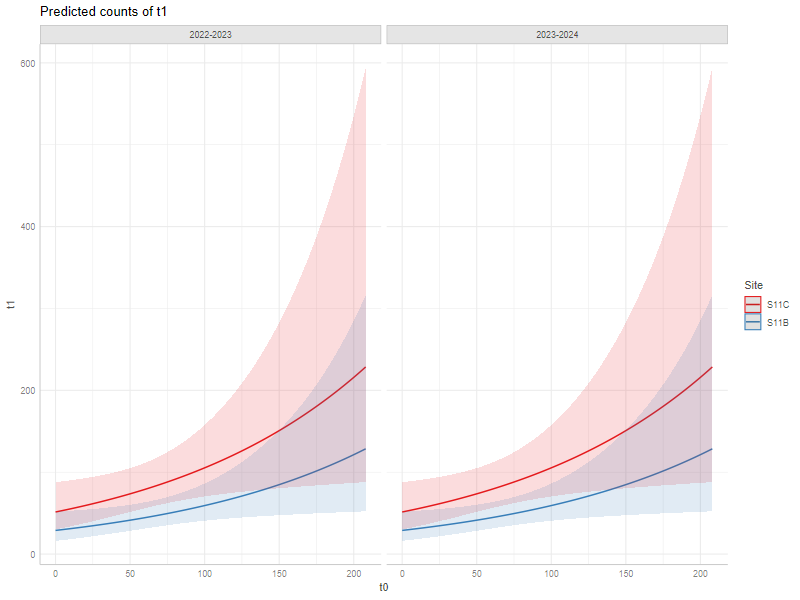

In [82]:
ggeffects::predict_response(
  BestModel,terms=c("t0[0:208]", #[0,208] represent the minimum and maximum individuals record in plot per month and pear stage(?)
          "Site","period"))%>%plot()



In [83]:

# Apply the same structure of the best model but for each stream
bestS11B<-update(BestModel,~0+t0+(1|period), data=filter(RepIm,Site=="S11B"))
bestS11C<-update(BestModel,~0+t0+(1|period), data=filter(RepIm,Site=="S11C"))



<!-- # 4. Inverse model implementation

<!--# FUNCTION WOODPAR REMOVED -->

## 4.1. Creates an working example[^1]

So, let's consider the following MPM:

$$
A= \begin{bmatrix}
S_{1,1} & R_{1,2} \\
S_{2,1} & S_{2,2} \\
\end{bmatrix}

\\

\text{where,} ~~ A=U+F

\\

U= \begin{bmatrix}
S_{1,1} & 0 \\
S_{2,1} & S_{2,2} \\
\end{bmatrix}
~~ \text{and} ~~ 
F= \begin{bmatrix}
0 & R_{1,2} \\
0 & 0 \\
\end{bmatrix}
$$

The respective MPM represents the individuals transition during the period Mar-May, represented by $U$

Non-zero elements in matrix $U$ are $S_{1,1}, S_{2,1}, \text{end}, S_{2,2}$.

Now, we creates an hypothetical matrix and the non-zero elements
 -->


In [84]:
AA <- matrix(c(1,1,0,0),ncol=2)
AA

nonzero<-which(AA> 0); nonzero

[1] 1 2

To run the `QPmat` function, we need to inform:
- Demographic restrictions, represented by matrix $C$;
- Non-zero elements already informed;
- All vital rates have same weight $b$ element.

Matrix C is described as: 

$$
C = 
\left(\begin{array}{ccc}  
  -1 & 0 & 0  \\          
  0 & -1 & 0  \\   
  0 & 0 & -1  \\   
  1 & 0 & 1  \\   
  0 & 1 & 0   \\ 
\end{array}\right)
~~~~~~~~ \text{representing,} ~~~~~  
\begin{array}{c}
  \ S_{1,1} ≤ 0 \\
  \ S_{2,1} ≤ 0\\
  \ S_{2,2} ≤ 0 \\
  \ S_{1,1} + S_{2,1} ≤ 1 \\
  \ S_{2,2} ≤ 1 \\
\end{array}
$$
Informing this to R, we have,




In [85]:
C<- rbind(
  c(-1,  0),  # -a11 ≤ 0
  c( 0, -1),  # -a21 ≤ 0
  c( 1,  1)   # a11 + a21 ≤ 1
)
b <- c(0, 0, 1)

print(C)


     [,1] [,2]
[1,]   -1    0
[2,]    0   -1
[3,]    1    1


# 5. Applying the quadratic programming

In [86]:
mpm_list_bkp<-mpm_list<-NULL
for(i in 1:length(all_census_ts)){
mpm_list_bkp[[i]]<-mpm_list[[i]]<-tryCatch(
		QPmat(all_census_ts[[i]]%>%as.matrix(), 
			C,
			b,
			nonzero),
 error = function(e) { return(NA)})
}

names(mpm_list)<-names(mpm_list_bkp)<-names(all_census_ts)

mpm_list[1]

$Plot_1_2022
     [,1] [,2]
[1,]    0    0
[2,]    1    0



## 5.1. Remove plots where vital rates could not be estimated

-   Two plots at S11B could not have demographic information estimated because individuals are close to zero.
-   Plots are:
-   Plot_19_2022 - Only adult individuals recorded?
-   Plot_15_2024 - Only 2 individuals in March

##### Decisions

-   Plot_15_2024 was below a extinction threshold, so, it is necessary to be included in the analyses.
-   Plot_19_2022 we cannot decided if it is a sampling error or a biological process so it was removed

In [87]:
# Detect plots with problems
problems_plots<-mpm_list_bkp[lapply(lapply(mpm_list_bkp,complete.cases),any,FALSE)=="FALSE"]

problems_plots

all_census_ts[names(problems_plots)]

# Create a list with a single MPM with all elements equal to zero
zero_mpm<-list()
zero_mpm[[1]]<-matrix(rep(0,4),2)

mpm_list_bkp[names(mpm_list_bkp) %in% names(problems_plots)]
mpm_list_bkp[names(mpm_list_bkp) == "Plot_15_2024"]<-zero_mpm  #Include zero matrices in the list of estiamted matrices
mpm_list_bkp[names(mpm_list_bkp) %in% names(problems_plots)]


#Census2022_ts$Plot_15_2022 #Show trajectory of the abundance
#Census2023_ts$Plot_15_2023
#Census2024_ts$Plot_15_2024

# Now make mpm_list being equal to mpm_list_bkp
mpm_list <- mpm_list_bkp[!names(mpm_list)=="Plot_19_2022"]

# 6. Quadratic programming efficiency
-   Simulate an hypothetical population to assess model's accuracy
  -   Hypothetical population was created based on the matrix structure we expect for *Parapiqueria*.
    -   Matrix is
        -   2x2
        -   Divided in juveniles and adults
        -   Does not includes recruitment because it cannot be estimated within year (March-May)
        -   We assume adults reproduce once and become senescent. So, stage $S_{2,2}$ represents senescent adults and cannot contribute to population growth rate. Two tests with and without the model were performed for efficiency;
            -   Senescent adults were kept in the matrix, as it helps to estimate demographic parameters, but must be removed during elasticity analyses
          


In [88]:
file.edit("ModelToyv1.R") 
source("ModelToyv1.R")

[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 2
[1] "2 1"
[1] "2 2"
[1] "2 3"
[1] "2 4"
[1] "2 5"
[1] "2 6"
[1] "2 7"
[1] "2 8"
[1] "2 9"
[1] "2 10"
[1] "2 11"
[1] "2 12"
[1] "2 13"
[1] "2 14"
[1] "2 15"
[1] "2 16"
[1] "2 17"
[1] "2 18"
[1] "2 19"
[1] "2 20"
[1] "2 21"
[1] "2 22"
[1] "2 23"
[1] "2 24"
[1] "2 25"
[1] "2 26"
[1] "2 27"
[1] "2 28"
[1] "2 29"
[1] "2 30"
[1] "2 31"
[1] "2 32"
[1] "2 33"
[1] "2 34"
[1] "2 35"
[1] "2 36"
[1] "2 37"
[1] "2 38

Warning message:
There were 28 warnings in `mutate()`.
The first warning was:
ℹ In argument: `stages = forcats::fct_relevel(...)`.
ℹ In group 1: `census = "3"` and `VR = "X1"`.
Caused by warning:
! 4 unknown levels in `f`: Statis[Immat], Growth[Immat.>Adult], Surv[Adult], and
Recruitment
ℹ Run ]8;;x-r-run:dplyr::last_dplyr_warnings()dplyr::last_dplyr_warnings()]8;; to see the 27 remaining warnings. 


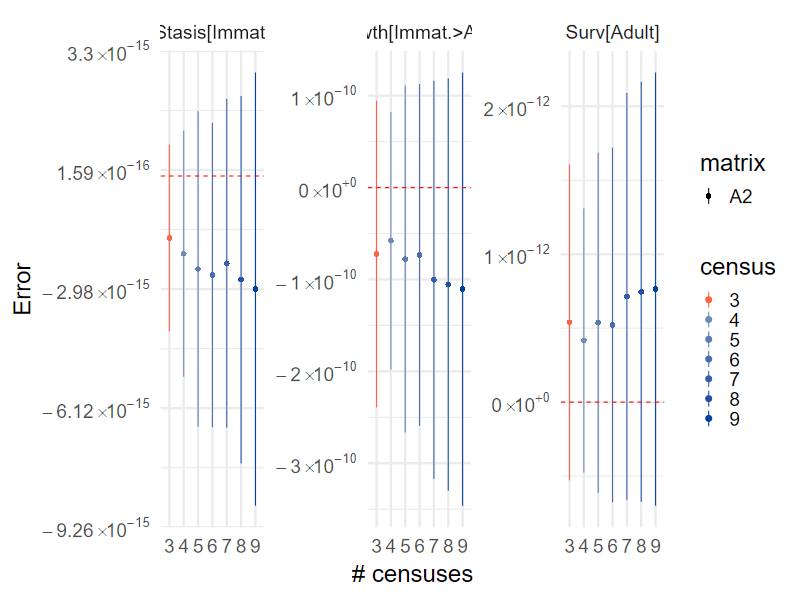

In [89]:
#the object VRs_dif_df was created in "ModelToyv1.R"
VRs_dif_df%>%
  filter(matrix=="A2")%>%
  ggplot(.,aes(x=census,y=Mean,group=census))+
  geom_pointrange(aes(ymin=Mean-SD,ymax=Mean+SD,
                      group=census,color=census,shape=matrix),
                  position = position_dodge2(width = 0.7))+
  ylab("Error")+xlab("# censuses")+
  scale_y_continuous(label=scientific_10)+
  scale_color_manual(values=c(
    '#ff6347', '#6e8ab6', '#5b7bb3', '#496daf', '#375fa9', '#2350a4', '#00429d'))+
  geom_hline(yintercept=0,color="red",linetype=2)+
  scale_x_discrete(labels=function(l) parse(text=l))+
  theme_minimal(base_size=24)+
  facet_wrap(.~stages,scales="free",ncol=3)

    

# 7. Producing finam matrix models

## 7.1 Remove senescent individuals for further analyses


In [90]:
mpm_list_s22<-mpm_list #Creates a new MPM list including S22
mpm_list<-Map(function(mat) { mat[2,2] <- 0; mat }, mpm_list) #Remove S22 for further analyses

mpm_list[[1]]
mpm_list_s22[[1]]

     [,1] [,2]
[1,]    0    0
[2,]    1    0

## 7.2. Merging recruitment with survival dependent vital rates

### 7.3. Separe MPMs by streams

Split plots according to the streams. - Plots 1-10 are placed in the S11C; - Plots 11-20 are placed in the S11B;


In [91]:
mpm_list_S11C<-mpm_list[grep("^Plot_([1-9]|10)_.*$", names(mpm_list))]
mpm_list_S11B<-mpm_list[grep("^Plot_(1[1-9]|20)_.*$", names(mpm_list))]

#Check
mpm_list_S11C%>%names()

 [1] "Plot_1_2022"  "Plot_10_2022" "Plot_2_2022"  "Plot_3_2022"  "Plot_4_2022" 
 [6] "Plot_5_2022"  "Plot_6_2022"  "Plot_7_2022"  "Plot_8_2022"  "Plot_9_2022" 
[11] "Plot_1_2023"  "Plot_10_2023" "Plot_2_2023"  "Plot_3_2023"  "Plot_4_2023" 
[16] "Plot_5_2023"  "Plot_6_2023"  "Plot_7_2023"  "Plot_8_2023"  "Plot_9_2023" 
[21] "Plot_1_2024"  "Plot_10_2024" "Plot_2_2024"  "Plot_3_2024"  "Plot_4_2024" 
[26] "Plot_5_2024"  "Plot_6_2024"  "Plot_7_2024"  "Plot_8_2024"  "Plot_9_2024" 

## 7.2. Build MPM $A$ for each stream

### 7.2.1. Transform Recruitment in matrix $F$

Each stream has a proper mean $F$ matrix

In [92]:
mean_matF_S11B<-matrix(
	c(0,0,
	exp(fixef(bestS11B)$cond[[1]]),
	  0),ncol=2)

mean_matF_S11C<-matrix(
	c(0,0,
	exp(fixef(bestS11C)$cond[[1]]),
	  0),ncol=2)


In [93]:
#Show matrix F
list(mean_matF_S11B, mean_matF_S11C)

[[1]]
     [,1]     [,2]
[1,]    0 1.009427
[2,]    0 0.000000

[[2]]
     [,1]     [,2]
[1,]    0 1.005278
[2,]    0 0.000000


### 7.2.2. Merging components of MPM $A = U + F$

In [94]:
mpm_list_recruit_S11C<-Map(`+`, mpm_list_S11C, list(mean_matF_S11C))
mpm_list_recruit_S11B<-Map(`+`, mpm_list_S11B, list(mean_matF_S11B))

# Merge in a single list for statistics
mpm_list_recruit_full<-c(mpm_list_recruit_S11C,mpm_list_recruit_S11B)

# Example
mpm_list_recruit_full[1]



# 8. Summary results

An ancillary function to optimise statistical report


In [95]:
statrep<- function(data, group_vars, value_var = "value") {
  data %>%
    group_by(across(all_of(group_vars))) %>%
    summarise(
      Mean = mean(.data[[value_var]], na.rm = TRUE),
      SD = sd(.data[[value_var]], na.rm = TRUE),
      N = n(),
      SE = SD / sqrt(N),
      CI = 1.96 * SE,
      lower95 = quantile(.data[[value_var]], 0.025, na.rm = TRUE),
      higher95 = quantile(.data[[value_var]], 0.975, na.rm = TRUE),
      .groups = "drop"
    ) %>%
    mutate(across(where(is.numeric), round, 2))
}



Transform vital rates into a data.frame to proceed with statistical analyses

In [96]:

vr.df<-data.frame(do.call(rbind,lapply(mpm_list_recruit_full,as.vector)),var="vr")%>%rownames_to_column(var = "VAR")%>%
as_tibble()%>%
  setNames(c("VAR","S1","S2","R","S4","var"))%>%
separate(VAR,sep="_",into = c("x", "Plot", "year"))%>%
select(-x)%>%
pivot_longer(S1:S4,values_to="value",names_to="vital_rate")%>%
mutate(Plot=as.numeric(Plot),
	 year=year)%>%
mutate(Site=ifelse(Plot<11,"S11C","S11B"))

## 8.1. Overall Vital rates

In [97]:

vr.df%>%
filter(vital_rate!=c("R","S4"))%>%
statrep(., group_vars = c("vital_rate"),value_var = "value")%>%print()



# A tibble: 2 × 8
  vital_rate  Mean    SD     N    SE    CI lower95 higher95
  <chr>      <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>    <dbl>
1 S1          0.16  0.16    59  0.02  0.04    0         0.5
2 S2          0.76  0.25    59  0.03  0.06    0.18      1  


## 8.2. Vital rates by plot

In [98]:
vr.df%>%
filter(vital_rate!=c("R","S4"))%>%
  statrep(., group_vars = c("vital_rate", "Site"),value_var = "value")%>%
    group_by(Site)%>% group_split()%>%print()

<list_of<
  tbl_df<
    vital_rate: character
    Site      : character
    Mean      : double
    SD        : double
    N         : double
    SE        : double
    CI        : double
    lower95   : double
    higher95  : double
  >
>[2]>
[[1]]
# A tibble: 2 × 9
  vital_rate Site   Mean    SD     N    SE    CI lower95 higher95
  <chr>      <chr> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>    <dbl>
1 S1         S11B   0.12  0.15    29  0.03  0.05    0         0.5
2 S2         S11B   0.81  0.26    29  0.05  0.09    0.17      1  

[[2]]
# A tibble: 2 × 9
  vital_rate Site   Mean    SD     N    SE    CI lower95 higher95
  <chr>      <chr> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>    <dbl>
1 S1         S11C   0.19  0.17    30  0.03  0.06     0       0.49
2 S2         S11C   0.72  0.24    30  0.04  0.09     0.2     1   



### 8.2.1. Checking if there is differences between plots

In [99]:
vr.df%>%
  filter(vital_rate!="R")%>%        # Recruitment need to be removed as it is a mean deterministic value, without variation. Note that difference in recruit was alread tested in the Recruitment section above
  select(-c(year,var))%>%
  nest(data=c(Plot,Site,value))%>%
  mutate(pairwise= map(data, ~ t.test(value ~ Site, data = .)))%>%
  pull(pairwise)%>%
  purrr::set_names(c("Stasis[Immat]", "Growth[Immat.>Adult]", "Surv[Adult]"))%>%
  tibble(
    Comparison = names(.),
    t_value = map_dbl(., ~ .x$statistic),
    df = map_dbl(., ~ .x$parameter),
    p_value = map_dbl(., ~ .x$p.value),
    conf_low = map_dbl(., ~ .x$conf.int[1]),
    conf_high = map_dbl(., ~ .x$conf.int[2]),
    mean_S11B = map_dbl(., ~ .x$estimate[1]),
    mean_S11C = map_dbl(., ~ .x$estimate[2])
  )




### 7.2.2. Checking if vital rates are correlated to year

In [100]:
# Similar to above. Main difference is in the nest process
vr.df%>%
  filter(vital_rate!="R")%>%
  select(-c(Plot,Site,var))%>%
  mutate(year=as.numeric(year))%>%
  nest(data=c(year,value))%>% #only year and value are considered here
  mutate(pairwise= map(data, ~ cor.test(.$value, .$year,method="pearson")))%>% #cor.test instead of t.test
  pull()%>%
  purrr::set_names(c("Stasis[Immat]", "Growth[Immat.>Adult]", "Surv[Adult]"))%>%
  tibble(
    Vital_rate = names(.),
    Correlation = map_dbl(., ~ .x$estimate[1]),
    conf_low = map_dbl(., ~ .x$conf.int[1]),
    conf_high = map_dbl(., ~ .x$conf.int[2]),
    t = map_dbl(., ~ .x$statistic),
    df = map_dbl(., ~ .x$parameter),
    p_value = map_dbl(., ~ .x$p.value))


Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `pairwise = map(data, ~cor.test(.$value, .$year, method =
  "pearson"))`.
Caused by warning in `cor()`:
! the standard deviation is zero 


Warning message:
There was 1 warning in `mutate()`.
ℹ In argument: `stages = forcats::fct_relevel(...)`.
Caused by warning:
! 1 unknown level in `f`: Statis[Immat] 


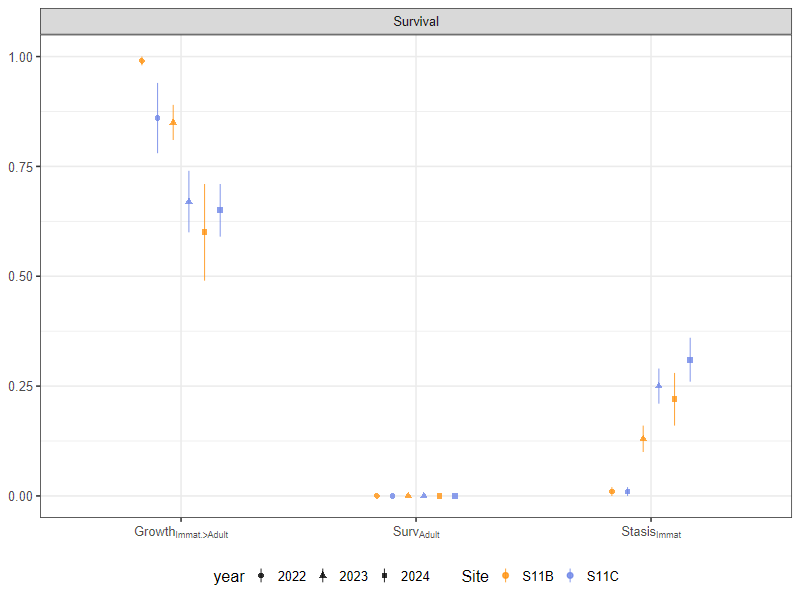

In [101]:
vr.df%>%
  statrep(., group_vars = c("vital_rate","year","Site"))%>%
# filter(vital_rate!="R")%>%
  mutate(VR="Survival")%>%
mutate(stages=case_when(vital_rate=="S1"~ "Stasis[Immat]",
				vital_rate=="S2"~ "Growth[Immat.>Adult]",
				vital_rate=="R"~ "Recruitment",
				vital_rate=="S4"~ "Surv[Adult]"))%>%
mutate(stages=forcats::fct_relevel(stages, c("Statis[Immat]","Growth[Immat.>Adult]", "Surv[Adult]","Recruitment")))%>%
filter(vital_rate!="R")%>%
ggplot(.,aes(y=Mean,x=stages,group=year))+
geom_pointrange(aes(ymin=Mean-SE,ymax=Mean+SE,color=Site,shape=year),alpha=0.8,
	position = position_dodge2(width = 0.4))+
scale_x_discrete(labels=function(l) parse(text=l))+
scale_color_manual(values=c("#ff9211","#6e86e7"))+
ylim(0,1)+
theme_bw(base_size=16)+
theme(legend.position="bottom")+
facet_grid(.~VR)+
xlab(NULL)+ylab(NULL)



In [102]:
lambsSite<-rbind(
do.call(rbind,lapply(mpm_list_recruit_S11C,lambda))%>%
	data.frame(Site="S11C",mod="model")%>%
			rownames_to_column(var = "VAR"),
do.call(rbind,lapply(mpm_list_recruit_S11B,lambda))%>%
	data.frame(Site="S11B",mod="model")%>%
			rownames_to_column(var = "VAR"))


In [103]:

#TESTING DIFFERENCES
t.test(lambsSite$.~lambsSite$Site)



In [104]:
lambsSite_df<-lambsSite%>%rename(., Lambda=.)%>%
as_tibble()%>%
separate(VAR,sep="_",into = c("x", "Plot", "year"))%>%
select(-x)%>%
mutate(Plot=as.numeric(Plot),
	 year=year)%>%
mutate(Site=ifelse(Plot<11,"S11C","S11B"))%>%
statrep(., group_vars = c("Site", "year"),value_var = "Lambda")

lambsSite_df

# A tibble: 6 × 9
  Site  year   Mean    SD     N    SE    CI lower95 higher95
  <chr> <chr> <dbl> <dbl> <dbl> <dbl> <dbl>   <dbl>    <dbl>
1 S11B  2022   1     0        9  0     0       1           1
2 S11B  2023   0.99  0.03    10  0.01  0.02    0.92        1
3 S11B  2024   0.85  0.31    10  0.1   0.19    0.18        1
4 S11C  2022   0.92  0.18    10  0.06  0.11    0.53        1
5 S11C  2023   0.94  0.15    10  0.05  0.09    0.61        1
6 S11C  2024   0.97  0.07    10  0.02  0.05    0.8         1

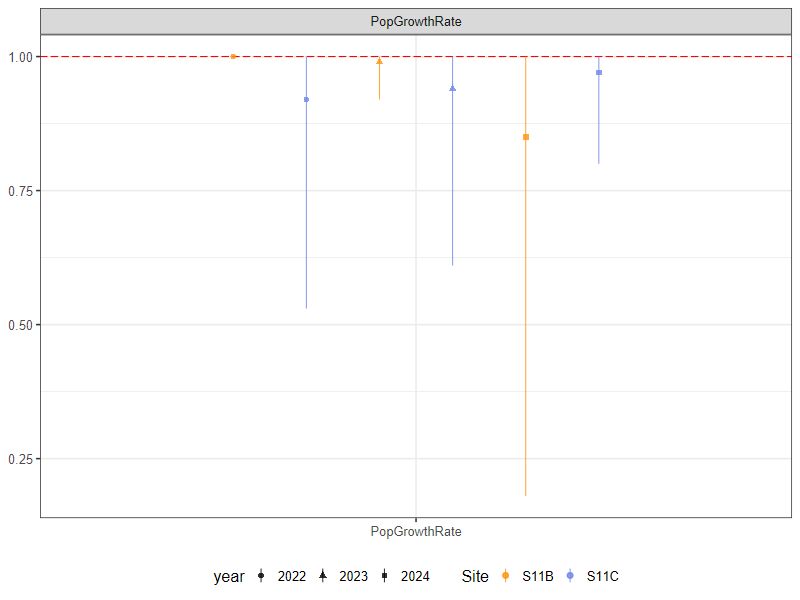

In [105]:
lambsPlot<-lambsSite_df%>%
mutate(VAR="PopGrowthRate")%>%
ggplot(.,aes(y=Mean,x=VAR,group=year))+
geom_hline(yintercept=1,col="red", linetype="longdash")+
geom_pointrange(aes(ymin=lower95,ymax=higher95,color=Site,shape=year),alpha=0.8,
	position = position_dodge2(width = 0.7))+
#  geom_line(aes(color = Site, group = Site), 
#            position = position_dodge2(width = 0.7))+
scale_x_discrete(labels=function(l) parse(text=l))+
scale_color_manual(values=c("#ff9211","#6e86e7"))+
theme_bw(base_size=16)+
theme(legend.position="bottom")+
facet_grid(.~VAR)+
xlab(NULL)+ylab(NULL)

lambsPlot



# 8. Applying demographic tools: elasticity and LTRE

## 8.1. Elasticities of mean demographic parameters


In [106]:
# Mean elasticity for Parapiqueria
elasticity(mean(c(mpm_list_recruit_S11C,mpm_list_recruit_S11B)))

# Elasticities in Site S11B
elasticity(mean(mpm_list_recruit_S11B))

# Elasticities in Site S11C
elasticity(mean(mpm_list_recruit_S11C))





## 8.2. Life Table Response Experiment (LTRE)


In [107]:
LTRE(mean(mpm_list_recruit_S11B), mean(mpm_list_recruit_S11C))



## 8.2. Life table response by year


In [108]:

LTREyear<-list(
  #2022
LTRE(
mean(mpm_list_recruit_S11B[grep("2022$", names(mpm_list_recruit_S11B), value = TRUE)]),
mean(mpm_list_recruit_S11C[grep("2022$", names(mpm_list_recruit_S11C), value = TRUE)])),

#2023
LTRE(
mean(mpm_list_recruit_S11B[grep("2023$", names(mpm_list_recruit_S11B), value = TRUE)]),
mean(mpm_list_recruit_S11C[grep("2023$", names(mpm_list_recruit_S11C), value = TRUE)])),

#2024
LTRE(
mean(mpm_list_recruit_S11B[grep("2024$", names(mpm_list_recruit_S11B), value = TRUE)]),
mean(mpm_list_recruit_S11C[grep("2024$", names(mpm_list_recruit_S11C), value = TRUE)]))
)

#Mean
LTREyear%>%mean()

#Variance
LTREyear%>%popbio::var2()





# 9. Extinction risk

Three steps must be performed first:

1.  Define the initial number of individuals based on the mean value of immatures and reproductives

2 Simulate vital rates to include in the model

3.  Create a set of matrices with these new estimated variables

## 9.1. Define the initial number of individuals


In [109]:

Mean_indiv<-Census_all_max%>%
  #filter(  Remove 1% dos dados para evitar outliers
  #  value < quantile(value,.995) & 
  #  value > quantile(value,.005))%>%
  group_by(stage)%>%
  summarise(Mean=mean(value),
            Median=median(value),
            sd=sd(value))

Mean_indiv





## 9.2. Simulate the vital rates

-   Simulate binomial distribution values from recruitment based on the best model

-   Simulate Survival, growth and stasis based on a beta distribution using beta function in `popbio` package



In [110]:
BestModel_coef<-(BestModel%>%summary%>%coef)$cond%>%exp()


#BestModel_coef[1,1]  # Check best model coeficients
#BestModel_coef[1,2]

# Simulating recruitment
rec_sim<-
  0.1+    #A small factor has been added to make sure individuals will not recruit zero indivíduals
  rnbinom(1000, 
          mu =   BestModel_coef[1,1],
          size = sigma(BestModel) #Desviation in the model
  )


# Simulating U matrices values
mean_vrs_period<-mean(mpm_list)
var_vrs_period<-var2(mpm_list)

s1_sim<-replicate(1000,betaval(mean_vrs_period[1],var_vrs_period[1]))
s2_sim<-replicate(1000,betaval(mean_vrs_period[2],var_vrs_period[2]))
s3_sim<-replicate(1000,betaval(mean_vrs_period[4],var_vrs_period[4]))






### 9.2.1. Visual validation of simulated parameters


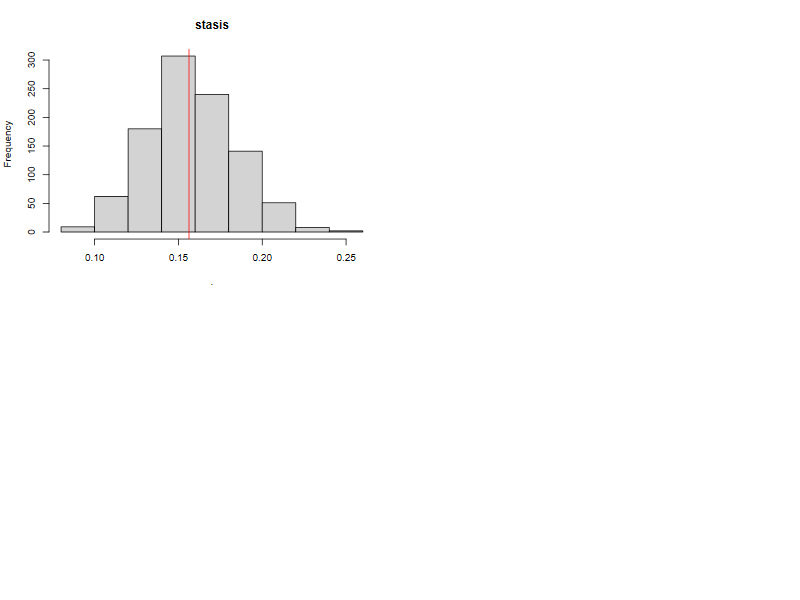

In [111]:

par(mfrow=c(2,2))
  s1_sim%>%hist(main="stasis")
  abline(v=mean_vrs_period[1],col="red")
  
  s2_sim%>%hist(main="growth")
  abline(v=mean_vrs_period[2],col="red")
  
  s3_sim%>%hist(main="survival")
  abline(v=mean_vrs_period[2],col="red")
  
  hist(rec_sim,breaks=30,main="Recrutamento",freq=F)  #Simulated recruitment
  (RepIm$t1/RepIm$t0)%>%hist(breaks=30,freq=F,add=T,col=alpha("orange",0.6))  #Observed recruitment
  abline(v=exp(parameters::parameters(BestModel)[1,2]),col="red") #Esimated recruitment



## 9.3. Produce simulated MPMs

-   Based on the simulated vital rates produced, we can now produce the simulated MPMs.

Define de stages and the MPM format



In [112]:

stages<-c("seed","Juvenile","Adult")

lifecycle_para <- expression(matrix2(c(
  s1,  recruit,
  s2, s3  ),   stages[-1] ))

vrstoch<-function(){
  vr <- list( s1=sample(s1_sim)[1],
              s2=sample(s2_sim)[1],
              s3=sample(s3_sim)[1],
              recruit=sample(rec_sim)[1])
  return(vr)
}

#Check if MPM is being built

eval(lifecycle_para, vrstoch())


### 9.3.1 Simulate several MPMs

In [113]:
#Create the matrices
StochA_sim<-replicate(10000,(eval(lifecycle_para, vrstoch())))

StochA <- lapply(seq(dim(StochA_sim)[3]), function(i) StochA_sim[,,i])

StochA[[1]]


# Mean lambda
lapply(StochA,lambda)%>%unlist%>%mean%>%print()%


# Lambda range
lapply(StochA,lambda)%>%unlist%>%range




: [1m[33mError[39m:[22m
[33m![39m unexpected input in "lapply(StochA,lambda)%>%unlist%>%mean%>%print()%"

### 9.3.2. Check values



Check lambda



In [ ]:
par(mfrow=c(2,2))

# Simulated data
hist(unlist(lapply(StochA, lambda)),
     freq = FALSE,ylim=c(0,3),
     breaks=c(0, 0.33, 0.70, 1.00, 1.31, 1.66, 2.00, 2.31, 2.65, 3.2),
     main="Simulated data", xlab="Population growth rate (lambda)")

#S11B
hist(unlist(lapply(mpm_list_recruit_S11B, lambda)),
     freq = FALSE,ylim=c(0,3),col=alpha("#ff9211", 0.2),
     breaks=c(0, 0.33, 0.70, 1.00, 1.31, 1.66, 2.00, 2.31, 2.65,  3.2),
     main="S11B",xlab="Population growth rate (lambda)")
#S11C

hist(unlist(lapply(mpm_list_recruit_S11C, lambda)),
     freq = FALSE,ylim=c(0,3),col=alpha("#6e86e7", 0.2),
     breaks=c(0, 0.33, 0.70, 1.00, 1.31, 1.66, 2.00, 2.31, 2.65,  3.2),
     main="S11C",xlab="Population growth rate (lambda)")

# All
hist(unlist(lapply(StochA, lambda)),
     freq = FALSE,ylim=c(0,3),
     breaks=c(0, 0.33, 0.70, 1.00, 1.31, 1.66, 2.00, 2.31, 2.65,  3.2),
     main="ALL",xlab="Population growth rate (lambda)")

hist(unlist(lapply(mpm_list_recruit_S11B, lambda)),
     freq = FALSE,add=T,col=alpha("#ff9211", 0.2),
     breaks=c(0, 0.33, 0.70, 1.00, 1.31, 1.66, 2.00, 2.31, 2.65,  3.2))

hist(unlist(lapply(mpm_list_recruit_S11C, lambda)),
     freq = FALSE,add=T,col=alpha("#6e86e7", 0.2),
     breaks=c(0, 0.33, 0.70, 1.00, 1.31, 1.66, 2.00, 2.31, 2.65,  3.2))



In [ ]:
## 9.4. Extinction growth rate

resultado<-stoch.quasi.ext(StochA, 
              n0 = Mean_indiv$Median[1:2], 
              Nx=Mean_indiv[3,3]/10,
              maxruns=10,
              tmax = 10, nreps=100)
matplot(resultado, xlab="Years", ylab="Cumulative extinction risk (%)", 
        type='l', lty=1, col="grey20", las=1,
        main="Extinction risk \n (Proportion of simulations crossing extinction threshold of 10% initial population")



In [ ]:

n_init<-c(50,50) # define initial population
n_threshold<-sum(n_init)*.10 # Define extinction threshold: 10% of the initial population size

#Project population for 10 years based on estimated parameters
projS11B_10<-stoch.projection(mpm_list_recruit_S11B, 
                              n_init,	#Estabelece meio indivíduo em cada estágio,logo, ao somar, teriamos quanto que a população doubrou,triplicou...
                              #	stable.stage(mean(mpm_list_recruit_S11B))*100,
                              tmax=10,nreps=1000)

projS11B_30<-stoch.projection(mpm_list_recruit_S11B, 
                              n_init,tmax=30,nreps=1000)

#Project population for 30 years based on estimated parameters
projS11C_10<-stoch.projection(mpm_list_recruit_S11C, 
                              n_init,tmax=10,nreps=1000)

projS11C_30<-stoch.projection(mpm_list_recruit_S11C, 
                              n_init,tmax=10,nreps=1000)



projALL_10<-stoch.projection(c(mpm_list_recruit_S11B,mpm_list_recruit_S11C),
                             n_init,tmax=10,nreps=1000)

projALL_30<-stoch.projection(c(mpm_list_recruit_S11B,mpm_list_recruit_S11C),
                             n_init,tmax=10,nreps=1000)





In [ ]:
#'-------------------------------------------------------------------------
# Create proptable_modif a special prop table ------------------
#'-------------------------------------------------------------------------
## Rationale  --------------
# proptable_modif is an adaptation of default prop.table
# This function allow to include FALSE or TRUE when there is no legitime true or false extinction 
#'-------------------------------------------------------------------------
proptable_modif <- function(data, threshold) {
  # equivalent to prop.table(table(apply(data,1,sum)> n_threshold))*100
  res <- table(factor(apply(data, 1, sum) > threshold, levels = c(FALSE, TRUE)))
  # Equivalent to prop.table(ext10.probS11B)*100
  prop <- prop.table(res) * 100
  return(prop)
}
##'-------------------------------------------------------------------------

apply(projS11C_30,1,sum)%>%range()
apply(projS11B_30,1,sum)%>%range()


# Chi-square of extinction rate between streams
data.frame(rbind(
  proptable_modif(projS11B_10, n_threshold),
  proptable_modif(projS11C_10, n_threshold)),
  row.names = c("S11B", "S11C"))%>%
  print()%>%chisq.test() %>%print()

data.frame(rbind(
  proptable_modif(projS11B_30, n_threshold),
  proptable_modif(projS11C_30, n_threshold)),
  row.names = c("S11B", "S11C"))%>%
  print()%>%chisq.test()%>%print()






> Os resultados do nosso modelo indicam que **mesmo na ausência de impacto, há uma pequena probabilidade de extinção local das populações (0.11%) em quatro anos**, **aumentando para até 3.45% em 10 anos**. Esses resultados são coerentes com os censos observados em campo. Por exemplo, todos os indivíduos desapareceram da parcela 15 riacho S11B no ano de 2024 (equivalente a uma extinção local nessa parcela). A redução das taxas vitais aumentou a probabilidade de extinção (Figura 7), sendo 14% no cenário onde as taxas vitais foram reduzidas em 10%. Diferente de Ipomoea cavalcantei, onde a redução do crescimento populacional se iniciou apenas no cenário no qual as taxas vitais foram reduzidas acima de de 25%; uma redução de 25% das taxas vitais em P. cavalcantei resultou um efeito muito mais dramático, reduzindo a probabilidade de viabilidade das populações para menos de 50% (46,17%; Figura 7). Padrão similar foi observado quando comparamos as consequências genéticas devido às reduções no tamanho população de ambas as espécies (ver resultado no tópico - Consequências genéticas da redução populacional).Os resultados do nosso modelo indicam que mesmo na ausência de impacto, há uma pequena probabilidade de extinção local das populações (0.11%) em quatro anos, aumentando para até 3.45% em 10 anos. Esses resultados são coerentes com os censos observados em campo. Por exemplo, todos os indivíduos desapareceram da parcela 15 riacho S11B no ano de 2024 (equivalente a uma extinção local nessa parcela). A redução das taxas vitais aumentou a probabilidade de extinção (Figura 7), sendo 14% no cenário onde as taxas vitais foram reduzidas em 10%. Diferente de Ipomoea cavalcantei, onde a redução do crescimento populacional se iniciou apenas no cenário no qual as taxas vitais foram reduzidas acima de de 25%; uma redução de 25% das taxas vitais em P. cavalcantei resultou um efeito muito mais dramático, reduzindo a probabilidade de viabilidade das populações para menos de 50% (46,17%; Figura 7). Padrão similar foi observado quando comparamos as consequências genéticas devido às reduções no tamanho população de ambas as espécies (ver resultado no tópico - Consequências genéticas da redução populacional).


In [ ]:
rbind(
  data.frame(projS11B_10,Site="S11B"),
  data.frame(projS11C_10,Site="S11C"))%>%
  mutate(total=rowSums(select_if(., is.numeric), na.rm = TRUE))%>%
  mutate(Mean=mean(total),
         Median=median(total))%>%
  ggplot(.,aes(x=total,group=Site))+
  geom_histogram(
    aes(y=..count../sum(..count..),
        fill=Site),
    position = 'identity',color="black",alpha=.3)+
  scale_fill_manual(values=c("#6e86e7","#ff9211"))



## 9.5 Simulating different scenarios

Create a function to automatise the vital rates reduction. This function is a adaptation of `stoch.quasi.ext` from `popbio` package.

This adaptation includes the parameter "damage" with a vector informing scenarios of vital rates reduction. Note all vital rates are impacted together.



In [ ]:
Myviab_func<-function (matrices, n0, Nx, tmax = 50, maxruns = 10, nreps = 5000, 
                       prob = NULL, sumweight = NULL, verbose = TRUE,damage=damage) {
  damage=damage
  if (is.list(matrices)) {
    matrices <- matrix(unlist(matrices), ncol = length(matrices))
  }
  x <- length(n0)
  if (is.null(sumweight)) {
    sumweight <- rep(1, x)
  }
  y <- dim(matrices)[2]
  ext <- matrix(numeric(maxruns * tmax), ncol = maxruns)
  for (h in 1:maxruns) {
    if (verbose) {
      message("Calculating extinction probability for run ", 
              h)
    }
    prob.ext <- numeric(tmax)
    for (i in 1:nreps) {
      n <- n0
      for (t in 1:tmax) {
        col <- sample(1:y, 1, prob = prob)
        A <- matrix(matrices[, col], nrow = x)
        n <- ((A-(A*damage)) %*% n)
        N <- sum(sumweight * round(n))
        if (N < Nx) {
          prob.ext[t] <- prob.ext[t] + 1
          break
        }
      }
    }
    prob.ext <- cumsum(prob.ext/nreps) #Extinctions by number of replications
    ext[, h] <- prob.ext
  }
  ext
}





-   Define de impacts. a sequence of impact from 0% to 50% reduction in vital rates


In [ ]:

sim_damage<-seq(0,0.5,by=0.05)
sim_damage%>%print()




Perform the simulation

In [ ]:
temp<-NULL
out<-NULL

tmax=11   #Years simulated (from t0 to t10)
for(i in 1:length(sim_damage)){
  temp<-Myviab_func(StochA, 
                    n0 = Mean_indiv$Median[1:2], 
                    Nx=Mean_indiv[3,3]/10,        #Mean_indiv[3,3]/10 representa 10% dos indivíduos médios
                    maxruns=10,                   # Número de réplicas em cada simulação?
                    tmax = tmax, nreps=1000,
                    damage=sim_damage[i])
  out[[i]]<-data.frame(Extinct.rate=apply(temp,1,mean),
                       SD=apply(temp,1,sd),
                       Dano=sim_damage[i],
                       t=seq(1,tmax,by=1))
  print(paste0("Simulating damage at ",sim_damage[i]*100,"%" ))
}





Calculate the number of simulations crossing the extinction threshold to extimate the persistence probability.


In [ ]:

viab_para<-do.call(rbind,out)%>%
  mutate(Persistprop=100-(Extinct.rate*100),
         ymin=100-((Persistprop-SD)*100),
         ymax=100-((Persistprop+SD)*100))
  
  viab_para[viab_para>100]<-100
viab_para[viab_para<0]<-0


viab_para%>%filter(t==10)%>%print()



In [ ]:

viab_para%>%
  #  mutate(dano=as.factor(dano))%>%
  ggplot(.,aes(x=t-1,y=Persistprop,group=Dano))+
  geom_line(aes(color=Dano*100))+
  geom_pointrange(aes(ymin=ymin, ymax=ymax,color=Dano*100))+
  #  viridis::scale_color_viridis(option="magma")+
  scale_color_stepsn(
    #    colours = c("red", "yellow", "green", "yellow", "red"),
    # colours = viridis::viridis(n = 7, option = "inferno",direction=-1) ,
    colours = rev(viridis::viridis(n = 5, option = "magma", direction = -1)))+ 
  theme_classic(base_size=24)+
  scale_x_continuous(breaks=seq(0,10,by=1),expand = c(0, 0))+
  scale_y_continuous(labels = scales::percent_format(scale = 1),
                     expand = c(0, 0),
                     breaks=c(0,10,seq(50,200,by=50)))+
  geom_hline(yintercept=10,color="tomato",linetype="dashed")+
  labs(color="Impacto/Redução (%)",
       y="Projeção populacional",
       x="Anos projetados")+
  theme(legend.position="right")
